# Introduction

Ce notebook présente une approche pour déterminer le genre d'une musique à travers les caractéristiques fournies par l'API spotify en utilisant des algorithmes de Machine Learning. Il s'agit d'une version simplifiée du notebook `final_nootebook` dans lequel les fonctions utilisées ne sont pas détayées mais stockées dans utils. Les hyperparamètres des modèles ont également état optimisés. Ce projet s'intègre dans le cadre du cours Python pour la Data Science de l'ENSAE Paris. Il a été mené par Tom Laflotte, Enzo Moran et Martin Conte.

Il suit le plan suivant:

I. Une première approche via l'API Spotify

1. Collecte des données

    a. Constitution d'un premier dataset
    
    b. Collecte du genre des artistes

2. Visualisation

II. Prédiction à l'aide d'une base de données Kaggle 

1. Préparation des données

    a. Gestion des valeurs

    b. Standardisation des variables continues

    c. Imputation des valeur manquantes

    d. Imputation des variables catégorielles *

2. Visualisation des données préparées

    


In [20]:
from utils import *
import matplotlib.pyplot as plt
import seaborn as sns

# I. Une première approche via l'API Spotify

Tout d'abord nous devons importer toutes les librairies qui nous seront nécessaires pour cette partie

## I.1. Collecte des données

Nous avons d'abord essayé de créer une base de données grâce à l'API Spotify.

### I.1.a. Constitution d'un premier dataset

Spotify ne met pas à disposition une quelconque base de donnée déjà constituée. Nous allons donc devoir faire des requêtes successives à l'API pour récolter les informations sur les morceaux choisis, afin de constituer notre premier dataset. Chaque requête permet d'obtenir les metadonnées d'un artiste donné, ou d'une playlist donnée. C'est ce que nous avons choisi de faire.

Pour minimiser le nombre de requêtes, nous sélectionnons une playlist de 10 000 morceaux déjà faite par un utilisateur Spotify, afin d'obtenir des informations sur chaque morceau qui la compose : titre, id, artist, artist_id. Ensuite, nous récupérons les informations qui nous intéressent sur chaque morceau : les track features, qui sont un tas d'indices quantitatifs Enfin, nous récupérons le genre qui n'est associé qu'à l'artiste, et pas au morceau. C'est ici une limite préoccupante : le genre qui est la variable à prédire n'est en fait que le genre de l'artiste et pas le genre véritable du morceau.

D'abord, on initialise le client Spotify pour l'obtention des données via l'API grâce au token d'accès avec la fonction `spotify_client`.

Ensuite, nous utilisons ce client pour notre requête sur la playlist de 10 000 morceaux.

Notre objectif final est d'obtenir un fichier csv compilant toutes les données fournies par l'API de Spotify dans un fichier csv.
Nous réalisons cela grâce à la fonction `get_playlist_data_to_csv`. Celle-ci fait appel à des fonctions intermédiaires:

- `fetch_playlist_tracks` permet d'obtenir des informations sur l'ensemble des musiques d'une playlist
- `fetch_artist_genre` permet d'obtenir le genre principal d'un 
- `fetch_track_data` permet de récupérer les informations qui seront utile à le modélisation
- `save_to_csv` enregistre le tout au csv


Du fait des restrictions de requêtes imposées par l'API de spotify, nous avons mis en place des requêtes par paquets de 100 chansons suivi d'une pause d'une minute, cette approche nous a permis de constituer une première base de données de 1500 musiques, en répétant ce procédé sur une plus longue période, il serait possible d'obtenir les données de l'ensemble de la playlist mais comme nous le détaillerons plus tard, nous n'avons pas retenu cette approche et nous contenterons de la base de données intermédiaire.

La requête suivante permet de constituer un premier dataset consitué des musiques de la playlist "Top 10 000 songs of All-Time":

In [ ]:
get_playlists_data_to_csv(['1G8IpkZKobrIlXcVPoSIuf'])

### I.1.b. Collecte du genre de la playlist

Nous avons réussi à enregistrer une première version de notre df que nous visualiserons en partie I. 2. Cependant, cette approche ne nous donne que le genre de l'artiste et pas nécessairement de la playlist. C'est pourquoi nous avons décidé d'adapter certaines de nos fonctions afin de collecter le genre des playlists et de collecter les données de playlists aux genres spécifiques. Le genre de la playlist sera ensuite assimilé à celui de l'artiste. A cet effet, nous avons ajouté la fonction `get_playlist_data_to_csv_with_genre`

In [ ]:
get_playlists_data_to_csv_with_genre({'rap' : '4KsrGBWG6gzBwGe9dx16OE', 
                                      'country' : '33mU9g6y8nKFAOyiISor0G',
                                      'blues' : '7BDUphylF8dfPKFo9Tvdr9',
                                      'metal' : '1yYEy4MtNLVScj74wcPR7w',
                                      'r_and_b' : '7CI3NR7rvCkgiLhch1qprf',
                                      'classical_music' : '5n9btvMZ52rxwozhQdKU7v',
                                      'jazz' : '79Bcltku1dcD08JcAM29kL',
                                      'pop' : '7gqtGYFoCR3tAqTtEUQZTw'})

Cette deuxième approche nous aurait permis de constituer un dataset plus précis mais nous n'avons pas pu la mettre en place. En effet, les conditions d'utilisation de l'API spotify ont été changées et il n'est plus possible de faire des requêtes donnant accès aux métadonnées des chansons. Notre Machine Learning utilisera donc un dataset Kaggle. Néanmoins, nous pouvons visualiser les données collectées en partie I.1.a

## I.2. Visualisation

Nous utilisons dans cette première partie la base de données constituée avec la méthode de la partie I.1 que nous avons stocké sur SSPCloud

In [ ]:
file_path = "/ponte/Projet_data/first_db.csv"

df = pd.read_csv("https://minio.lab.sspcloud.fr" + file_path)

In [ ]:
df.head()

### I.2.a. Pré-Nettoyage

On supprime les colonnes de la database servant uniquement à identifier les musiques:


In [5]:
df=df.drop(['track Name','track_id','type','id','uri','track_href', 'analysis_url'],axis=1)

Il semble qu'il y ait de nombreux genres musicaux qui en réalité pourraient être considérés comme des sous-genres, nous allons donc les regrouper.

In [ ]:
genres=df['genre'].unique().tolist()
print(genres)

In [8]:
categories = {
    "rap": [
        'hip hop', 'rap', 'dirty south rap', 'melodic rap', 'conscious hip hop', 'alternative hip hop', 'chicago rap', 
        'bronx hip hop', 'detroit hip hop', 'gangster rap', 'canadian hip hop', 'atl hip hop', 'lgbtq+ hip hop', 'bboy', 'hip pop'
    ],
    "rock": [
        'classic rock', 'album rock', 'alternative rock', 'dance rock', 'hard rock', 'soft rock', 'irish rock', 'piano rock', 
        'australian rock', 'detroit rock', 'british blues', 'garage rock', 'classic garage rock', 'glam rock', 'art rock', 
        'alternative metal', 'folk rock', 'country rock', 'protopunk', 'space rock', 'experimental rock', 'modern rock', 
        'surf music', 'pub rock', 'new wave', 'dance-punk'
    ],
    "pop": [
        'pop', 'dance pop', 'pop rock', 'ambient pop', 'alternative pop', 'bedroom pop', 'canadian pop', 'british soul', 
        'classic country pop', 'barbadian pop', 'bubblegum pop', 'torch song', 'french shoegaze', 'new wave pop', 
        'brill building pop', 'beatlesque', 'britpop', 'art pop', 'candy pop','power pop','electropop', 'experimental pop'
    ],
    "blues": [
        'blues', 'blues rock', 'classic soul', 'r&b', 'british blues', 
        'louisiana blues', 'acoustic blues'
    ],
    "jazz":['cool jazz', 'bebop', 
        'avant-garde jazz', 'big band', 'hot jazz', 'jazz blues', 'gospel', 'soul jazz'],
    "country": [
        'folk', 'american folk revival', 'appalachian folk', 'ambient folk', 'bluegrass', 'bluegrass gospel', 'celtic punk', 
        'country', 'country rock', 'bakersfield sound', 'arkansas country', 'cowboy western', 'alternative americana'
    ],
    "electro": [
        'edm', 'house', 'acid house', 'ambient', 'ambient house', 'ambient pop', 'dance-punk', 'electro', 'indietronica', 
        'balearic', 'atmospheric dnb', 'filter house', 'hi-nrg', 'big beat'
    ],
    "classical": [
        'african-american classical', 'baroque pop', 'torch song', 'classic soundtrack', 'adult standards'
    ]
}


In [ ]:
def assign_category(genre):
    for category, keywords in categories.items():
        if genre in keywords:
            return category
        elif genre=='N/A':
            return 
    return "other"

df["category"] = df["genre"].apply(assign_category)

### I.2.b Visualisation des données

Analysons tout d'abord les variables catégoriques de notre dataset:

In [11]:
categorical_var = df.copy().select_dtypes(include=["object"]).columns.to_list()
categorical_var.extend(["key","mode","time_signature","explicit"])

In [ ]:
df[categorical_var].nunique()

Pour les variables avec un faible nombre de valeurs différentes, nous allons les représenter sous forme d'histogramme

In [ ]:
df_barplot = df[["explicit","category","mode","time_signature","key"]].copy()
plt.figure(figsize=(10,10))

for c,var in enumerate(df_barplot.columns):
  # compute frequency of each unique value
  df_plot= df_barplot[var].value_counts(normalize=True).to_frame("frequency").reset_index(names=var)
  df_plot["frequency"] = df_plot["frequency"]*100

  # plot the barplot
  plt.subplot(3,2,c+1)
  sns.barplot(data=df_plot, x=var, y="frequency")
  plt.title(str(var))
  plt.xlabel("")
  plt.ylabel("")

plt.tight_layout()

Nous observons que la catégorie qui est le regroupement du genre est très mal répartie, cela risque de poser problème pour notre modèle car il s'agit de la variable cible qui devrait donc être répartie de façon uniforme afin de ne pas créer de biais dans notre modèle.

Pour les colonnes 'artists' et 'genre' nous allons visualiser le top10 des artistes les plus représentés

In [ ]:
# Pie chart for 'artists'
artist_counts = df['artists'].value_counts().head(10) 
plt.figure(figsize=(10, 6))
plt.pie(artist_counts, labels=artist_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Top 10 Artists Distribution')
plt.axis('equal')  
plt.show()

# Pie chart for 'genre'
genre_counts = df['genre'].value_counts().head(10)  
plt.figure(figsize=(10, 6))
plt.pie(genre_counts, labels=genre_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Top 10 Genres Distribution')
plt.axis('equal')  
plt.show()

De même, la répartition des genres dans notre dataset n'est pas adaptée à notre problématique. Nous avons donc tenté l'approche détaillée en partie I.1.b. qui s'est avérée infructueuse du fait d'un changement de la politique de Spotify https://developer.spotify.com/blog/2024-11-27-changes-to-the-web-api nous allons donc, pour la suite utiliser un dataset de 30 000 musiques issu du site Kaggle https://www.kaggle.com/datasets/joebeachcapital/30000-spotify-songs

# II. Prédiction à l'aide d'une base de données Kaggle

## II.1. Préparation des données


Dans cette partie nous allons nous occuper du preprocess c'est à dire du nettoyage et de la mise en forme des données en vue de la création du modèle

Importation des modules nécessaires : 

In [23]:
file_path = "/tlaflotte/genre_detector/spotify_tracks.csv"

df = pd.read_csv("https://minio.lab.sspcloud.fr" + file_path)

On commence par éliminer toutes les colonnes qui contiennent des noms et des identifiants et qui n'apportent donc aucune information intéressante pour notre étude. Nous choisissons aussi de supprimer la colonne popularity car celle-ci est calculée de façon très obscure et comporte de trop nombreuses valeurs nulles pour les imputer alors même que les chansons sont célèbres.

In [24]:
df.drop(columns=["track_name","track_id","track_artist","track_album_id","track_album_name","track_album_release_date",
       "playlist_name", "playlist_id","track_popularity"], inplace = True)

### II.1.a Gestion des valeurs aberrantes 

D'abord, on va s'occuper des outliers. On va les identifier avec la méthode du z-score en considérant comme outliers les valeurs ayant un Zscore en valeur absolue supérieur à 3. On peut se permettre cela car les distributions de la plupart des variables sont proches de gaussiennes (voir-ci dessous), même si certaines variables font exceptions notamment tempo, valence et track_popularity.

In [ ]:
continuous_var = [
       'danceability', 'energy', 'loudness', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms']
plt.figure(figsize=(10,12))

for c,var in enumerate(continuous_var):
  plt.subplot(6,2,c+1)
  sns.kdeplot(data=df[continuous_var], x=var, fill=var)
  plt.title(str(var))
  plt.xlabel("")
  plt.ylabel("")

plt.tight_layout()

In [ ]:
outliers_zscore = count_outliers_zscore(df)

count_outliers_zscore(df)


On identifie un petit nombre d'outliers et rien ne nous indique que ces valeurs sont absurdes ou fausses et non juste des valeurs qui sortent un peu de l'ordinaire. Ainsi plutôt que de supprimer les lignes en question, on va plutôt winsorizer les valeurs.

In [27]:
df_winsorized = winsorize_outliers(df, ['danceability', 'energy', 'loudness', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'tempo','duration_ms'], 3)

In [ ]:
df.describe()

In [ ]:
df_winsorized.describe()

On remarque ainsi que certaines valeurs extrêmes ont été modifiées, sans que les statistiques les plus basiques (moyenne, variance, médiane et quartiles) ne soient significativement impactées. On peut donc remplacer notre tableau par ce nouveau tableau winsorisé.

In [30]:
df = df_winsorized

### II.1.b Standardisation des variables continues 

In [31]:
columns_to_standardize = ['danceability', 'energy', 'loudness', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
        'duration_ms']

scaler = StandardScaler()
df_standardized = df.copy()
df_standardized[columns_to_standardize] = scaler.fit_transform(df_standardized[columns_to_standardize])

Vérifions désormais que les colonnes de df_standardized sont bel et bien standardisées, avant de remplacer df par ce nouveau
tableau 

In [ ]:
plt.figure(figsize=(10,12))

for c,var in enumerate(continuous_var):
  plt.subplot(6,2,c+1)
  sns.kdeplot(data=df_standardized[continuous_var], x=var, fill=var)
  plt.title(str(var))
  plt.xlabel("")
  plt.ylabel("")
    
plt.tight_layout()

In [ ]:
# Calculons plutôt la moyenne et la variance des colonnes standardisées
for col in columns_to_standardize:
    mean = df_standardized[col].mean()
    variance = df_standardized[col].var()
    print(f"Variable : {col}")
    print(f"Moyenne : {mean:.6f}")
    print(f"Variance : {variance:.6f}\n")

Les courbes ont bien changées mais visuellement il est difficile de dire que la standardisation a été correctement effectuée. En revanche, les calculs de moyenne et de variance ne laissent pas de doute, la standardisation est réussie. On peut donc remplacer df par notre nouveau tableau aux variables continues standardisées.

In [34]:
df = df_standardized

### II.1.c Imputation des valeur manquantes

In [ ]:
df.isna().sum()

Nous devons imputer les valeurs manquantes dans 2 colonnes : liveness et valence. Nous allons pour cela comparer 3 modèles, la régression linéaire, random forest et Xgboost. 
Ainsi, pour notre comparaison, pour chaque modèle nous allons faire un test (en divisant notre jeu de données), et alors nous calculerons à la fois :
- La MAE (Erreur absolue Moyenne) qui mesure la moyenne des écarts absolus entre les valeurs prédites par le modèle et les valeurs réélles
- Le R2 (Coefficient de détermination) mesurant la proportion de variance des données expliquée par le modèle.
Les résultats vont nous permettre de savoir quel modèle est le plus performants entre les 3. C'est avec ce modèle que nous ferons donc la prédiction des valeurs manquantes dans les colonnes liveness et tempo
Nous allons naïvement utiliser toutes les autres variables (à l'exception de playlist-genre et playlist_subgenre) comme variables prédictives.

In [36]:
predictors = [ 'speechiness', 'instrumentalness', 'energy', 'danceability', 'acousticness', 'tempo', 
              'duration_ms', 'loudness', 'key', 'mode']

#### Avec une régression linéaire : 

In [ ]:
impute_with_linear_regression(df, 'liveness', predictors)

impute_with_linear_regression(df, 'valence', predictors)

Les résultats ne sont pas satisfaisants, les erreurs moyennes absolues sont assez éloignées de 1 et les coefficients de détermination sont faibles.

#### Avec random forest : 

In [38]:
df_intermediary = impute_with_random_forest(df, target_column='liveness', predictors=predictors)

df_rf = impute_with_random_forest(df_intermediary, target_column='valence', predictors=predictors)


In [ ]:
mae_liveness, r2_liveness = test_random_forest_imputation(df, target_column='liveness', predictors=predictors)
print(f"Liveness - MAE : {mae_liveness:.4f}, R^2 : {r2_liveness:.4f}")

mae_valence, r2_valence = test_random_forest_imputation(df, target_column='valence', predictors=predictors)
print(f"Valence - MAE : {mae_valence:.4f}, R^2 : {r2_valence:.4f}")

Les valeurs, quoique loin d'être parfaites, sont déjà plus satisfaisantes 

#### Avec xgboost : 

In [41]:
df_intermediary_xg, liveness_model = impute_with_xgboost(df, target_col='liveness', predictors=predictors)

df_xg, valence_model = impute_with_xgboost(df_intermediary_xg, target_col='valence', predictors=predictors)

In [ ]:
mae_liveness, r2_liveness = evaluate_xgboost_model(df_intermediary_xg, liveness_model, 'liveness', predictors)
print(f"Liveness - MAE: {mae_liveness:.4f}, R^2: {r2_liveness:.4f}")

mae_valence, r2_valence = evaluate_xgboost_model(df_xg, valence_model, 'valence', predictors)
print(f"Valence - MAE: {mae_valence:.4f}, R^2: {r2_valence:.4f}")

Les valeurs sont encore une fois décevantes, et moins satisfaisantes encore qu'avec random forest.

Ainsi, en se basant sur le R2 et la MAE c'est avec le random forest que l'on obtient les meilleures résultats c'est à dire les plus petites MAE et les plus grands R2. C'est donc avec ce modèle qu'on va imputer les NaNs.

In [43]:
df = df_rf

### II.1.d Imputation des variables catégorielles 

In [ ]:
categorical_var = ['playlist_genre', 'playlist_subgenre', 'key', 'mode']
df[categorical_var].nunique()

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x='playlist_subgenre', data=df)
plt.title('Répartition des catégories de subgenre')
plt.xticks(rotation=90)
plt.show()

In [ ]:
print(df['playlist_subgenre'].value_counts(normalize=True))

Les subgenre ont tous des proportions différentes, on peut ainsi les encoder en créant une nouvelle colonne playlist_subgenre_encoded qui contient la proportion du subgenre dans le dataset, cette colonne permet d'identifier le subgenre, on peut donc supprimer lea colonne subgenre. On a désormais des valeurs numériques.

In [ ]:
df_encoded = df.copy()

subgenre_proportions = df_encoded['playlist_subgenre'].value_counts(normalize=True)
df_encoded['playlist_subgenre_encoded'] = df_encoded['playlist_subgenre'].map(subgenre_proportions)
df_encoded = df_encoded.drop(columns=['playlist_subgenre'])

df_encoded.head()

In [48]:
df = df_encoded

Le tableau df ne possède désormais plus de valeurs aberrantes (selon la méthode avec les Zscore que l'on a utilisé), les variables continues ont été standardisées. De plus, les valeurs manquantes ont été standardisées et la variables catégorielle playlist_subgenre a été encodée.

Le code suivant permet de sauvegarder le nouveau dataframe en format csv, il est ainsi possible de le télécharger et de l'enregistrer sur onyxia : 

In [59]:
#df.to_csv('data_tracks_cleaned.csv', index=False)

## II.2. Visualisation des données préparées

Pour faciliter la lecture de ce notebook nous importons directement le fichier préparé à l'aide de la partie précédent, notamment pour éviter le temps computationnel lié au machine learning

In [60]:
file_path = "/ponte/Projet_data/data_tracks_cleaned.csv"

df = pd.read_csv("https://minio.lab.sspcloud.fr" + file_path)

In [ ]:
df.head()

### II.2.a. Analyse multivariée

In [49]:
continuous_vars=['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']
categorical_vars=['key', 'mode',  'playlist_genre', 'playlist_subgenre_encoded']

df[categorical_vars] = df[categorical_vars].astype('category')

Commençons tout d'abord par observer la matrice des corrélations pour nos variables continues. Cela pourrait permettre d'éliminer des variables fortement corrélées.

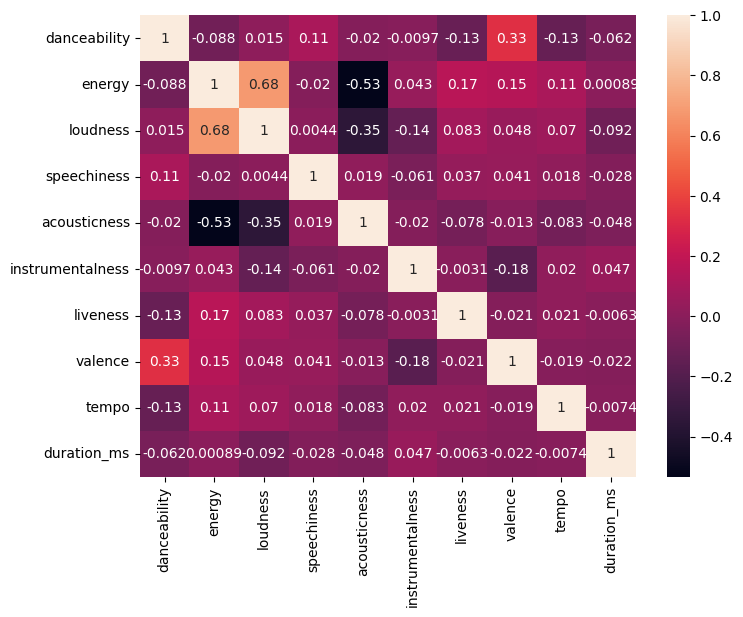

In [50]:
plt.figure(figsize=(8,6))
sns.heatmap(df[continuous_vars].corr(),annot=True);

La corrélation la plus forte que nous observons est entre `energy` et `acousticness`. Celle-ci est de -0.53, ce chiffre est assez élevé et pourrait nous permettre de laisser de côté l'une de ces deux colonnes, néanmoins nous choisissons de la garder. En effet, normalement on considère qu'un colonne peut être supprimer si la corrélation est supérieure  à 0.8. 

Pour mieux visualiser les écarts entre les différentes variables dans la prédiction du genree, nous allons tracer des boxplots

In [ ]:
plt.figure(figsize=(20, 40))

for i, var in enumerate(continuous_vars):
    plt.subplot(6, 2, i+1)
    sns.boxplot(x='playlist_genre', y=var, data=df)
    plt.title(f'Boxplot of {var} by Genre')
    plt.xlabel('Decoded Genre')
    plt.ylabel(var)

plt.tight_layout()
plt.show()


In [ ]:
fig, axes = plt.subplots(len(continuous_vars),sharex=True, figsize=(10,20))

for ax, var in zip(axes, continuous_vars):
  sns.kdeplot(data=df, x=var, hue="playlist_genre", fill="playlist_genre",ax=ax);
  ax.set_title(var)
  ax.set_xlabel("")
  ax.set_ylabel("")

plt.tight_layout()

- Le niveau de `danceability` est assez élevé pour les genres EDM et Latin. A l'inverse, le genre Rock semble avoir une médiane plus basse, indiquant que les chansons rock sont globalement moins dansantes. Les genres Pop, Rap et R&B montrent une distribution similaire avec une médiane modérée. Cela peut être dû au fait que ces dernières musiques sont des genres récents et que la frontière entre les genres est plus fine aujourd'hui.

- `EDM` a l'énergie la plus élevée, avec une médiane haute une distribution très concentrée. C'est en effet un genre de musique très rythmé. `Rock`, `Rap` 
et `Latin` montrent également une bonne énergie, tandis que `Pop` et `R&B` ont des niveaux plus modérés. En effet, ce type de chansons est souvent plus calme.

- `Rap` présente une valeur élevée de "speechiness", ce qui est attendu étant donné que ce genre repose beaucoup sur les paroles.

- `EDM` et `Rock` sont les genres les plus bruyants ce qui est cohérent. La plage de valeurs est plus large pour `Pop` et `Rap`. Cela démontre que ces genres peuvent être parfois calmes et parfois plus énergiques, observation que l'on retrouvait sur la variable energy

- `Rap` présente une valeur élevée de "speechiness", ce qui est attendu étant donné que ce genre repose beaucoup sur les paroles.

- Les chansons de `R&B` et `Latin` sont souvent plus acoustiques. Alors que `EDM` est très électronique (valeur proche de 0 pour acousticness) ce qui fait sens.

- la `liveness` est proche de 0 ce qui montre que les musiques sont quasiment toutes des versions studio

En conclusion les genres musicaux semblent montrer des tendances claires dans leur répartition, par exemple:

- EDM est énergique, rapide et souvent instrumental.
- Rap se distingue par une "speechiness" élevée 
- Latin est dansant, joyeux, et acoustique.

Ces tendances permettent d'identifier des différences claires entre les genres de musique ce qui nous permettra de mener à bien la classification lors de la phase de modélisation.


### II.2.b. Vérification du poids des variables

Pour vérifier si nous ne pourrions pas enlever des variables, nous allons mener une ACP et un random Forest simplement pour savoir le poids que ce modèle attribue à chaque variable

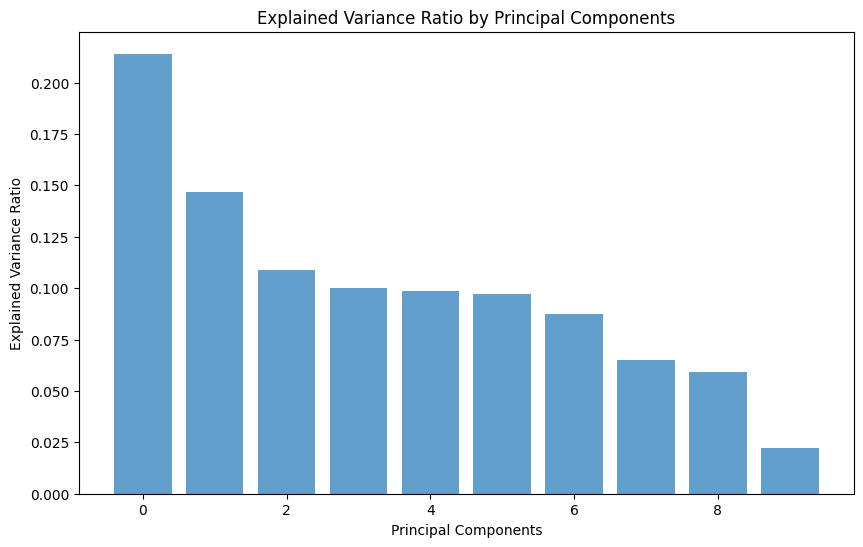

In [51]:
df_pca=df[continuous_vars]
# Perform PCA
pca = PCA()
pca.fit(df_pca)
# Get the explained variance ratio
explained_variance = pca.explained_variance_ratio_
# Plot the explained variance ratio
plt.figure(figsize=(10, 6))
plt.bar(range(len(explained_variance)), explained_variance, alpha=0.7, align='center')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio by Principal Components')
plt.show()

L'ACP ne nous permet pas de réduire notre dataframe à quelques composantes principales, en effet, les deux premières composantes n'incluent qu'une faible part d'explication de la variance. Cela se traduit aussi dans la part de chaque varible dans les composantes principales tracée ci-dessous:

In [ ]:
components = pd.DataFrame(pca.components_, columns=df_pca.columns)
plt.figure(figsize=(12, 10))
sns.heatmap(components, annot=True, cmap='coolwarm', xticklabels=df_pca.columns, yticklabels=[f'PC{i+1}' for i in range(len(components))])
plt.title("Contributions des variables aux composantes principales")
plt.xlabel("Variables")
plt.ylabel("Composantes principales")
plt.show()

Afin de vérifier si des composantes qualitatives pourraient être supprimées, nous réalisons un random Forest pour évaluer le poids de chaque variable: 

In [ ]:
# Séparer les caractéristiques (features) et la cible (target)
X = df.drop('playlist_genre', axis=1)
y = df['playlist_genre']

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X, y)

# Extraire l'importance des variables
importances = model.feature_importances_
feature_names = X.columns

# Créer un DataFrame pour visualiser les importances
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Afficher les importances
print(importance_df)

playlist_subgenre_encoded occupe une importance forte, nous pourrions n'utiliser que cette variable pour notre étude. Cependant, cette variable contient en réalité l'information du genre, nous allons donc la supprimer du dataframe.

In [115]:
df=df.drop(['playlist_subgenre_encoded'],axis=1)

In [ ]:
# Séparer les caractéristiques (features) et la cible (target)
X = df.drop('playlist_genre', axis=1)
y = df['playlist_genre']

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X, y)

# Extraire l'importance des variables
importances = model.feature_importances_
feature_names = X.columns

# Créer un DataFrame pour visualiser les importances
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Afficher les importances
print(importance_df)

Nous pourrions supprimer certaines variables comme mode, key et liveness mais nous allons pour l'instant les garder dans notre modèle.

## II.3. Modélisation

### II.3.a. Random Forest

Tout d'abord, nous séparons la variable cible (le genre) des autres variables. Ensuite, nous divisons ces ensembles en deux parties : une pour entraîner le modèle et une autre pour le tester. Étant donné que notre jeu de données est organisé par genre, nous spécifions qu'il doit être divisé aléatoirement en utilisant l'argument `shuffle=True`.

In [ ]:
features = df.copy()

genres = np.array(features['playlist_genre'])
features = features.drop(['playlist_genre'], axis = 1)
feature_list = list(features.columns)
features = np.array(features)

train_features, test_features, train_genres, test_genres = train_test_split(features, genres, test_size = 0.2, random_state = 0, shuffle = True)
print('Training Features Shape:', train_features.shape)
print('Training Genres Shape:', train_genres.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Genres Shape:', test_genres.shape)

Comme détaillé dans le notebook final_notebook, nous avons procédé à un ajustement des hyperparamètres du modèle, nous pouvons directement entraîner l'algorithme de random Forest avec les bons hyperparamètres.  

In [ ]:
rf = RandomForestClassifier(n_estimators=4000, max_features='sqrt', max_depth=20, min_samples_split=2, min_samples_leaf=1, bootstrap=True, criterion='gini' ,random_state=0)

rf.fit(train_features, train_genres)

predictions = rf.predict(test_features)


errors = zero_one_loss(test_genres, predictions, normalize=True)
print('zero_one_loss error normalized:', errors)

# Accuracy Score
accuracy_test = accuracy_score(test_genres, predictions)
print('accuracy_score on test dataset :', accuracy_test)

print(classification_report(predictions, test_genres))